<a href="https://colab.research.google.com/github/preetam01/M.Tech-Dissertation/blob/main/Text_Level_Graph_Neural_Network_v0_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **# Dataset: Twitter Sentiment Analysis**(Using Text Level GNN)

# **# 1. Import Libraries/Dataset**


In [ ]:
# DataFrame
import pandas as pd

#Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation

# Scikit-learn
from sklearn.model_selection import train_test_split

# Matplotlib for Graph Ploting
import matplotlib.pyplot as plt


# Utility
import re
import numpy as np
import matplotlib.pyplot as plt # Import matplotlib for data visualisation
from sklearn.metrics import confusion_matrix

#For glove
import torch
import torchtext

#For calcualtion of cosine semilarity
from scipy import spatial

#For Graph building
import networkx as nx

#Graph building
import networkx as nx

#Removing Stopwords
from nltk.corpus import stopwords

In [ ]:
# DATASET
DATASET_COLUMNS = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"


# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"


**#. Import Data Set for Sentiment Analysis using Googe Drive (Below is the backup option in case kaggle API having issues to load data.

In [ ]:
# Code to read csv file into Colaboratory:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv(r"/content/drive/My Drive/Dissertation/Kaggle Sentiment140.csv",encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

**#. Import Data Set for Sentiment Analysis directly from Kaggle**

In [ ]:
#!mkdir -p ~/.kaggle

In [ ]:
#!cp kaggle.json ~/.kaggle/

In [ ]:
#!ls ~/.kaggle

In [ ]:
#!cp kaggle.json ~/.kaggle/

In [ ]:
#!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
#!echo '{"username":"preetamkumar","key":"02e539250914c9fea2c057a45b87339b"}' > /root/.kaggle/kaggle.json
#!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
#!kaggle datasets download -d kazanova/sentiment140 -p /content

In [ ]:
#!unzip \*.zip

In [ ]:
#dataset = pd.read_csv('training.1600000.processed.noemoticon.csv' , encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [ ]:
print(len(df))

1600000


In [ ]:
#Selecting a sample for the testing purpose
df = df.sample(100000)
df = df.reset_index(drop=True)
dataset = df
print(len(dataset))

100000


In [ ]:
dataset.columns

Index(['sentiment', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [ ]:
dataset.describe()

,sentiment,ids
count,100000.000000,1.000000e+05
mean,2.009600,1.998239e+09
std,1.999987,1.940285e+08
min,0.000000,1.467819e+09
25%,0.000000,1.956815e+09
50%,4.000000,2.001992e+09
75%,4.000000,2.176942e+09
max,4.000000,2.329206e+09


In [ ]:
dataset.head(5)

,sentiment,ids,date,flag,user,text
0,0,2232196955,Thu Jun 18 19:35:04 PDT 2009,NO_QUERY,kazere,is busy cleaning windows and getting ready to ...
1,0,1754966796,Sun May 10 07:53:54 PDT 2009,NO_QUERY,natmarshall,Meeewsic. I just wanna get back to the studio ...
2,4,1969209153,Fri May 29 23:20:08 PDT 2009,NO_QUERY,GericaQuinn,"@RASOfficial well yur neither, so i won't expe..."
3,0,2263974715,Sun Jun 21 02:22:55 PDT 2009,NO_QUERY,monica_mills,had a fantabulous weekend! now onto that payc...
4,4,2061846505,Sat Jun 06 21:44:59 PDT 2009,NO_QUERY,on3_g,@juaneladio u need uncomment the alias in the ...


In [ ]:
dataset.tail()

,sentiment,ids,date,flag,user,text
99995,0,1972650554,Sat May 30 09:37:33 PDT 2009,NO_QUERY,Jacky_ds,@courtneyyy3 ok i miss this http://bit.ly/mHYT2
99996,0,2002439310,Tue Jun 02 04:13:02 PDT 2009,NO_QUERY,katizzle,@dannymasterson me too!! but i have to wait fo...
99997,0,2005872748,Tue Jun 02 10:18:35 PDT 2009,NO_QUERY,limitedmage,No Kid Icarus tho.
99998,4,2000590855,Mon Jun 01 22:28:04 PDT 2009,NO_QUERY,debbbbbie,@taylorswift13 http://twitpic.com/6g790 - well...
99999,0,1563848545,Mon Apr 20 00:32:39 PDT 2009,NO_QUERY,KaylieFinneran,"Is on her way to work, in this gorgeous weathe..."


In [ ]:
#Removing the unnecessary columns.
dataset = dataset.drop(columns = ["ids", "date", "flag", "user"])

# **# 2. Data Visualization**

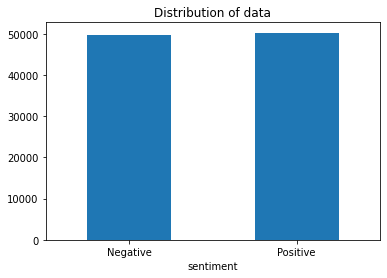

In [ ]:
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

In [ ]:
dataset.sentiment.unique()

array([0, 1])

In [ ]:
dataset.groupby('sentiment').nunique()

,text
sentiment,
0,49585
1,50121


In [ ]:
print ("No of postive sentiment tweets:")
n_positive = len(dataset[dataset['sentiment'] == 1])
print(n_positive)

No of postive sentiment tweets:
50240


In [ ]:
print ("No of negative sentiment tweets:")
n_negative = len(dataset[dataset['sentiment'] == 0])
print(n_negative)

No of negative sentiment tweets:
49760


In [ ]:
# Print at least 2 tweets from each class of data set for the sanity check that labels match the text
# Print +ve reviws
print('Print at least 2 tweets from positive sentiment:')
dataset_pos = dataset[dataset['sentiment'] == 1]
dataset_pos.head(5)

Print at least 2 tweets from positive sentiment:


,sentiment,text
2,1,"@RASOfficial well yur neither, so i won't expe..."
4,1,@juaneladio u need uncomment the alias in the ...
6,1,@julieannee haha yeah
14,1,"In corona, great flight"
16,1,it's all a bit of fun really


In [ ]:
# Print at least 2 tweets from each class of data set for the sanity check that labels match the text
# Print -ve reviws
print('Print at least 2 tweets from negative sentiment:')
dataset_neg = dataset[dataset['sentiment'] == 0]
dataset_neg.head(5)

Print at least 2 tweets from negative sentiment:


,sentiment,text
0,0,is busy cleaning windows and getting ready to ...
1,0,Meeewsic. I just wanna get back to the studio ...
3,0,had a fantabulous weekend! now onto that payc...
5,0,@_iWade_ it was $98. I'm having an issue tho c...
7,0,Rain. BAH! I want to be playing guitar not sat...


# **#3. Data Pre-processing**

In [ ]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}


In [ ]:
#Removing Twitter Handles(@user)
#User Defined function to remove patten
#Removing Twitter Handles(@user)
#User Defined function to remove patten
#Removing Emojis

def preprocess(tweet):
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
        
                  
    # Replace all URls with 'URL'
    tweet = re.sub(urlPattern,' URL',tweet)
     # Replace all emojis.
    for emoji in emojis.keys():
        tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
    # Replace @USERNAME to 'USER'.
    tweet = re.sub(userPattern,' USER', tweet)        
    # Replace all non alphabets.
    tweet = re.sub(alphaPattern, " ", tweet)
    
    return tweet

In [ ]:
dataset['text'] = dataset['text'].apply(preprocess)

In [ ]:
#dataset1 = dataset
dataset.head(5)


,sentiment,text
0,0,is busy cleaning windows and getting ready to ...
1,0,Meeewsic I just wanna get back to the studio ...
2,1,USER well yur neither so i won t expect to s...
3,0,had a fantabulous weekend now onto that payc...
4,1,USER u need uncomment the alias in the bashr...


In [ ]:
def preprocess_2(tweet):
      sequencePattern   = r"(.)\1\1+"
      tweet = re.sub('www',' ', tweet)   
      tweet = re.sub('WWW',' ', tweet)
      tweet = re.sub('USER',' ', tweet)
      tweet = re.sub('user',' ', tweet)
      tweet = re.sub('URL',' ', tweet)
      tweet = re.sub('url',' ', tweet)   
       # Replace 3 or more consecutive letters by ' '.
      tweet = re.sub(sequencePattern,' ',  tweet)
      return tweet

In [ ]:
dataset['text'] = dataset['text'].apply(preprocess_2)

In [ ]:
print(len(dataset))

100000


In [ ]:
dataset_sentiment = dataset.sentiment
dataset_text = dataset.text
dataset_text = dataset_text.str.lower()
dataset_text.head(5)

0    is busy cleaning windows and getting ready to ...
1    m wsic  i just wanna get back to the studio an...
2     well yur neither  so i won t expect to see yo...
3    had a fantabulous weekend now onto that paych ...
4      u need uncomment the alias in the  bashrc file 
Name: text, dtype: object

In [ ]:
#Function to create a graph from the node list and p value(defines the maximum nos of edge 1 node can have.)
def Graph(node,p):
  G = nx.Graph()
  G.add_nodes_from(node)

#Creating the edges from the node list based on value of p (i.e. if p =2 then each node is connected to previous 2 nodes.). 
  edge = []
  

  for i in range (0,len(node)):
      for j in range (1,(p+1)):
          if((i+j)< len(node)):
              edge.append([node[i],node[i+j]])
  G.add_edges_from(edge)  
  return G  

In [ ]:
#Function to update the egde values with co-occurance probability using Glove.
def Update_Prob_Adj_Mat(Graph):
  node = list(Graph.nodes)
  Adj_Matrix = nx.to_numpy_matrix(Graph)
  Adj_Matrix = np.array(Adj_Matrix)
  m = Adj_Matrix.shape[0]
  n = Adj_Matrix.shape[1]
  for i in range(0,m):
    for j in range(0,n):
      if (i != j):                    #For i=j the adjacency matrix element will be always 0 hence this should be excluded.
        vector1 = glove[node[i]]
        vector2 = glove[node[j]]
        normalize_vector1 = tf.nn.l2_normalize(vector1,0)  # Normalize the word vector
        normalize_vector2 = tf.nn.l2_normalize(vector2,0)  # Normalize the word vector
        # Calculate the norm value for both the word vector. 
        a = tf.reduce_sum(tf.multiply(normalize_vector1,normalize_vector1))
        b = tf.reduce_sum(tf.multiply(normalize_vector2,normalize_vector2))
        a = tf.cast(a, float, name=None)
        a = a.numpy()
        b = tf.cast(b, float, name=None)
        b = b.numpy()   
        if (a!=0 and b !=0):    # If any one of the norm of the word vector is 0 then it should be execluded as the cosine similarlity will be nan.
          prob =  1 - spatial.distance.cosine(vector1, vector2) #cosine_similarity between 2 glove vector
          Adj_Matrix[i][j] = prob
  return  Adj_Matrix

In [ ]:
# This function prints a given graph 

def print_graph(graph):

    pos = nx.spring_layout(graph)  # positions for all nodes

    # nodes
    nx.draw_networkx_nodes(graph, pos, node_size=1200)

    # edges
    nx.draw_networkx_edges(graph, pos, edgelist=graph.edges, width=3)

    # labels
    nx.draw_networkx_labels(graph, pos, font_size=10, font_family="sans-serif")

     # labels
    nx.draw_networkx_edge_labels(graph, pos, font_size=10, font_family="sans-serif")

    plt.axis("off")
    plt.show()

In [ ]:
#Node embedding function
def node_embedding(node):
  x= len(node)
  y = 100 #Number of Dimension for Node embedding
  w2v = np.empty((x,y), float)
  for i in range (0, len(node)):
    if (i< len(node)):
      T = glove[node[i]]
      Vec = T.numpy()
      w2v[i] = Vec
  return w2v

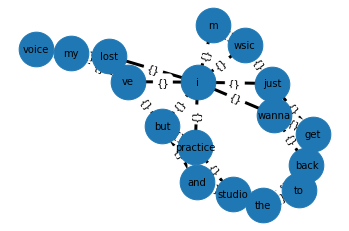

In [ ]:
#Example of Text Level Graph Creation using the value of p=2.
ex =1
node1 = dataset_text[ex].split()
Graph1 = Graph(node1,2)
print_graph(Graph1)

In [ ]:
#Message Passing between the nodes of the text level graph

def msg_pass(node,Adj_Mat,w2v,n):    # n is a trainable variable(value between 0 to 1) for node n that indicates how much information of rn should be kept
  x= len(node)
  y = 100 #Number of Dimension for Node embedding
   
  Mn_Temp = np.empty((4,y),float) # Temporary Matrix to hold the calculation of w2v[row] * edge[i][j] weight
  Mn = np.empty((1,y), float) #Matrix to captur the highestest value in each dimension for each node(word) processing
  Temp = np.empty((1,100), float) # Temporary Matrix used for capturing the value of multiplication of the edge weight and w2v of that word.
  w2v_new_Temp = np.empty((x,y), float)#Matrix to capture all Mn for each node(word) in the graph 
  w2v_new= np.empty((x,y), float)#Final word embeddd Matrix to capture updated with message passing from linked nodes(words)
  
  for i in range (0, x):
    for j in range ((i-p), (i+p+1)):
      if ( (j>=0) & (j != i) & (j<len(node))):
        Temp = Adj_Mat.item(i,j)*w2v[i]
        Temp = Temp.reshape(1,100)
        Mn_Temp = np.append(Mn_Temp, Temp , axis = 0)
        Mn_Temp = np.delete(Mn_Temp, 0,0)
    Mn = np.amax(Mn_Temp, axis = 0)
    Mn = Mn.reshape(1,100)
    w2v_new[i]= w2v_new[i]+(1-n)*Mn[0] + n*w2v[i] 
  w2v_new = np.nan_to_num(w2v_new)
  return w2v_new

In [ ]:
#Creation of Text Level Graph
import networkx as nx
import numpy as np

def text_level_graph(token,p,n):

  G = Graph(token,p)
  # Adj_Matrix = nx.to_numpy_matrix(G)
  # Adj_Matrix = np.array(Adj_Matrix)
  
 
  #Node embedding function
  node = list(G.nodes)
  Adj_Matrix = Update_Prob_Adj_Mat(G)
  Adj_Matrix = np.array(Adj_Matrix)
  w2v = node_embedding(node)
  w2v_new = msg_pass(node,Adj_Matrix,w2v,n)


  n1 = (w2v_new.shape[0]-1) #Determine the no of rows in the w2v_new matrix. This value will be used to inform the no of iteration for the 
  #for loop to add the elements of a column together.

  node_emb_total = np.empty((1,100), dtype = np.float32) # Define the Numpay Array(Matrix) with a dimension of 1 x 100 to capture the final node embedding value post msg passign aggregation.

  for i in range (0,n1):
    node_emb_total[0] = node_emb_total[0] + w2v_new[i]
  return node_emb_total

  

In [ ]:
# glove = torchtext.vocab.GloVe(name="6B", # trained on  Twitter corpus
#                               dim=100)   # embedding size = 100

In [ ]:
glove = torchtext.vocab.GloVe(name="twitter.27B", dim = 100)

.vector_cache/glove.twitter.27B.zip: 1.52GB [04:46, 5.31MB/s]                            
100%|█████████▉| 1193513/1193514 [00:51<00:00, 23211.63it/s]


#Start of testing and debugging

In [ ]:
#To test that Glove is active.

list_word = ['I', 'am', 'proud', 'of', 'you', 'spymaster']
a = glove[list_word[3]]
b = glove[list_word[4]]
normalize_a = tf.nn.l2_normalize(a,0)
# normalize_b = tf.nn.l2_normalize(a,0)
# c = tf.reduce_sum(tf.multiply(normalize_a,normalize_b))
# c = tf.cast(c, float, name=None)

# c = c.numpy()
c = tf.reduce_sum(tf.multiply(normalize_a,normalize_a))
c = tf.cast(c, float, name=None)

c = c.numpy()
c

1.0

#End of testing and debugging**

In [ ]:
dataset_text[300]

'i lack the skills needed to assemble a bicycle for a 6 year old girl please boo me as i walk by '

Preparation of input data matrix 'X' (New embedding matrix updated with the message passing) for the entire Tweeter dataset.

In [ ]:
l = len(dataset) # No of rows in dataset which will be use for the no iteration to prepare the text level graph
p=2
n = 0.5
TG_w2v_Matrix_final = np.empty((0,100),dtype = np.float32) #Define the final Text Level W2V matrix after message passing agreegation. Which will be input feature matrix to ML model
node_emb_total = np.zeros((1,100), dtype = np.float32)



for i in range (0, l):
  token = dataset_text[i].split()
  node_emb_total = np.zeros((1,100), dtype = np.float32)
  if (node_emb_total[node_emb_total > 1E3] is True):
    print(node_emb_total[0])
  node_emb_total[0] = node_emb_total[0] + text_level_graph(token,p,n)
  
  TG_w2v_Matrix_final = np.append(TG_w2v_Matrix_final, node_emb_total, axis = 0)
  
  # TG_w2v_Matrix_final = np.array(TG_w2v_Matrix_final) # Commented for performance issue


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in add


In [ ]:
# To check the final word2vector matrix has incorporated the total number texts. The number of rows should be same as the number of texts in the dataset
# and the number of column should be same as number of feature in node2vector embedding.
min_value = np.min(TG_w2v_Matrix_final)
print(min_value)
max_value = np.max(TG_w2v_Matrix_final)
print(max_value)

-inf
inf


In [ ]:
TG_w2v_Matrix_final[TG_w2v_Matrix_final <= -1E308] = -1E20

In [ ]:
TG_w2v_Matrix_final[TG_w2v_Matrix_final >= 1E50] = 1E20

In [ ]:
min_value = np.min(TG_w2v_Matrix_final)
print(min_value)
max_value = np.max(TG_w2v_Matrix_final)
print(max_value)

-8.0264145e+30
9.34887e+25


In [ ]:
dataset_sentiment.to_numpy()
dataset_sentiment.shape[0]

100000

In [ ]:
num_classes = len(np.unique(dataset_sentiment))
num_classes

2

#**#4.Model Building**


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(TG_w2v_Matrix_final, dataset_sentiment, test_size=0.2, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
X_data = TG_w2v_Matrix_final
Y_data = dataset_sentiment
assert X_train.shape[0] == Y_train.shape[0]
assert X_test.shape[0] == Y_test.shape[0]

# Train data samples: 80000
# Test data samples: 20000


In [ ]:
# X_train = tf.cast(X_train, tf.float32)
# Y_train = tf.cast(Y_train,tf.int32)
# X_test = tf.cast(X_train, tf.float32)
# Y_test = tf.cast(Y_train,tf.int32)

In [ ]:
#Print the head to check the X_train dataset
Y_train

45029    1
97602    0
68872    0
28951    1
98026    1
        ..
66524    0
30971    1
74572    0
20843    1
34703    1
Name: sentiment, Length: 80000, dtype: int64

In [ ]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(80000, 100) (20000, 100) (80000,) (20000,)


In [ ]:
# opt = Adam(learning_rate=0.01)
# model.compile(optimizer = opt, loss =cross_entropy_loss, metrics=['accuracy'])

In [ ]:
#Define a function for the loss function

# Initialize weight parameter to all 1 and bias(number of classes) to 0.
num_features = 100
num_classes = len(np.unique(dataset_sentiment))

# W = tf.Variable(tf.ones([num_features, num_classes]), name="weight")
# b = tf.Variable(tf.zeros([num_classes]), name="bias")

# Initialize weight parameter  and bias(number of classes) with random number.
W = tf.Variable(tf.random.uniform([num_features, num_classes]), name="weight")
b = tf.Variable(tf.random.uniform([num_classes]), name="bias")


def logistic_regression (x):
  x = tf.cast(x, tf.float32)
  y = tf.matmul(x, W) + b
  y_pred = tf.nn.softmax(tf.keras.activations.relu(y))
  return y_pred

def cross_entropy_loss(y_true, y_pred):
  y_true = tf.one_hot(y_true, depth=num_classes) #Encode label to a one hot vector.
  y_pred = tf.clip_by_value(y_pred, 1e-9, 1.0) ## Clip prediction values to avoid log(0) error.
  #loss = tf.reduce_mean(-tf.reduce_sum( y_true * tf.math.log(tf.clip_by_value(y_pred, 1e-10, 1.0)))) 
  loss = tf.math.multiply_no_nan(-((y_true, tf.math.log(y_pred))+ tf.math.multiply_no_nan((1- y_true), tf.math.log(1-y_pred))))
  # loss = tf.nn.softmax_cross_entropy_with_logits(y_pred, y_true, axis=-1, name=None)
  #cross_entropy = -tf.reduce_sum(y_*tf.log(tf.clip_by_value(y_conv,1e-10,1.0)))
  loss = tf.where(tf.math.is_nan(loss), tf.zeros_like(loss), loss)
  loss = tf.math.reduce_mean(-tf.reduce_sum(loss))
  return loss


Start of Debugging for nan issue

In [ ]:
#X_train = tf.cast(X_train, float)
# X_train = tf.cast(X_train, tf.float16)
#X_train.shape

End of debugging nad testing of nan issue

In [ ]:
model = keras.Sequential()
model.add(layers.Dense(100, activation="relu" ,kernel_regularizer=keras.regularizers.l2(l=0.0001)))
model.add(layers.Dense(1, activation="Softmax"))

In [ ]:
# model.save("model", save_format='tf')
opt = Adam(learning_rate=0.01)

model.compile(optimizer = opt, loss = 'binary_crossentropy' , metrics=['accuracy'])




In [ ]:
model_1 = keras.Sequential()
model_1.add(keras.layers.Dense(100, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.0001)))
model_1.add(keras.layers.Dropout(0.5))
model_1.add(keras.layers.Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.0001)))

model_1.add(keras.layers.Dense(1, activation='sigmoid'))



In [ ]:
opt = Adam(learning_rate=0.01)

# model_1.compile(optimizer = opt, loss ='binary_crossentropy', metrics=['accuracy'])
model_1.compile(optimizer = opt, loss =cross_entropy_loss, metrics=['accuracy'])



In [ ]:
no_of_epcohs = 100
gradient_batch_size = 32

history = model.fit(X_train, 
                    Y_train,
                    validation_split = 0.2,
                    steps_per_epoch = 5,
                    epochs= no_of_epcohs,
                    batch_size=gradient_batch_size, verbose = 1)


model.summary()

Epoch 1/100
5/5 [==============================] - 2s 199ms/step - loss: 8.7757 - accuracy: 0.4250 - val_loss: 7.6096 - val_accuracy: 0.5013
Epoch 2/100
5/5 [==============================] - 1s 161ms/step - loss: 6.5789 - accuracy: 0.5688 - val_loss: 7.6067 - val_accuracy: 0.5013
Epoch 3/100
5/5 [==============================] - 1s 161ms/step - loss: 6.6722 - accuracy: 0.5625 - val_loss: 7.6059 - val_accuracy: 0.5013
Epoch 4/100
5/5 [==============================] - 1s 163ms/step - loss: 6.8624 - accuracy: 0.5500 - val_loss: 7.6058 - val_accuracy: 0.5013
Epoch 5/100
5/5 [==============================] - 0s 113ms/step - loss: 7.7202 - accuracy: 0.4938 - val_loss: 7.6059 - val_accuracy: 0.5013
Epoch 6/100
5/5 [==============================] - 0s 106ms/step - loss: 7.7202 - accuracy: 0.4938 - val_loss: 7.6058 - val_accuracy: 0.5013
Epoch 7/100
5/5 [==============================] - 0s 109ms/step - loss: 7.8154 - accuracy: 0.4875 - val_loss: 7.6057 - val_accuracy: 0.5013
Epoch 8/100
5

In [ ]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss N/A')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

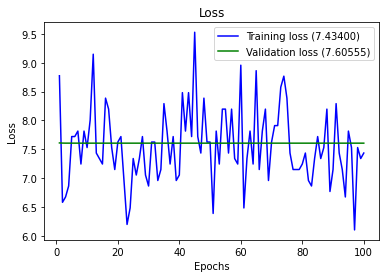

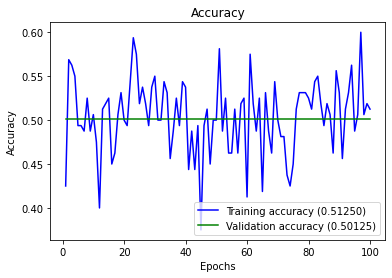

In [ ]:
plot_history(history)

In [ ]:
# Model Evaluation
test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest accuracy:', test_acc)


625/625 - 1s - loss: 7.5301 - accuracy: 0.5062

Test accuracy: 0.5062000155448914


In [ ]:
l = len(dataset) # No of rows in dataset which will be use for the no iteration to prepare the text level graph
p=2
n = 0.05
TG_w2v_Matrix_final1 = np.empty((0,100),dtype = np.float32) #Define the final Text Level W2V matrix after message passing agreegation. Which will be input feature matrix to ML model
node_emb_total = np.zeros((1,100), dtype = np.float32)



for i in range (0, l):
  token = dataset_text[i].split()
  node_emb_total = np.zeros((1,100), dtype = np.float32)
  if (node_emb_total[node_emb_total > 1E3] is True):
    print(node_emb_total[0])
  node_emb_total[0] = node_emb_total[0] + text_level_graph(token,p,n)
  
  TG_w2v_Matrix_final1 = np.append(TG_w2v_Matrix_final1, node_emb_total, axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in add


In [ ]:
TG_w2v_Matrix_final1.shape

(100000, 100)

In [ ]:
TG_w2v_Matrix_final1[TG_w2v_Matrix_final1 <= -1E308] = -1E20

In [ ]:
TG_w2v_Matrix_final1[TG_w2v_Matrix_final1 >= 1E50] = 1E20

In [ ]:
min_value = np.min(TG_w2v_Matrix_final1)
print(min_value)
max_value = np.max(TG_w2v_Matrix_final1)
print(max_value)

-1.21464e+27
1.2818709e+38


In [ ]:
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(TG_w2v_Matrix_final1, dataset_sentiment, test_size=0.2, random_state=37)
print('# Train data samples:', X_train1.shape[0])
print('# Test data samples:', X_test1.shape[0])
X_data = TG_w2v_Matrix_final1
Y_data = dataset_sentiment
assert X_train1.shape[0] == Y_train1.shape[0]
assert X_test1.shape[0] == Y_test1.shape[0]

# Train data samples: 80000
# Test data samples: 20000


In [ ]:
no_of_epcohs = 15
gradient_batch_size = 32

history1 = model.fit(X_train1, 
                    Y_train1,
                    validation_split = 0.2,
                    steps_per_epoch = 5,
                    epochs= no_of_epcohs,
                    batch_size=gradient_batch_size, verbose = 1)

model.summary()

Epoch 1/15
5/5 [==============================] - 0s 108ms/step - loss: 6.3856 - accuracy: 0.5813 - val_loss: 7.6570 - val_accuracy: 0.4979
Epoch 2/15
5/5 [==============================] - 1s 161ms/step - loss: 7.4340 - accuracy: 0.5125 - val_loss: 7.6570 - val_accuracy: 0.4979
Epoch 3/15
5/5 [==============================] - 0s 103ms/step - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.6570 - val_accuracy: 0.4979
Epoch 4/15
5/5 [==============================] - 0s 107ms/step - loss: 6.8622 - accuracy: 0.5500 - val_loss: 7.6570 - val_accuracy: 0.4979
Epoch 5/15
5/5 [==============================] - 1s 161ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.6570 - val_accuracy: 0.4979
Epoch 6/15
5/5 [==============================] - 0s 100ms/step - loss: 8.2918 - accuracy: 0.4563 - val_loss: 7.6570 - val_accuracy: 0.4979
Epoch 7/15
5/5 [==============================] - 1s 162ms/step - loss: 7.1481 - accuracy: 0.5312 - val_loss: 7.6570 - val_accuracy: 0.4979
Epoch 8/15
5/5 [====

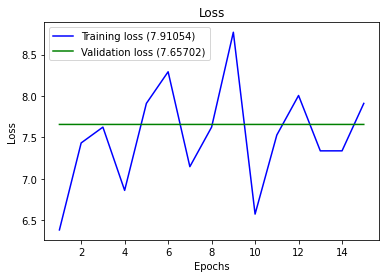

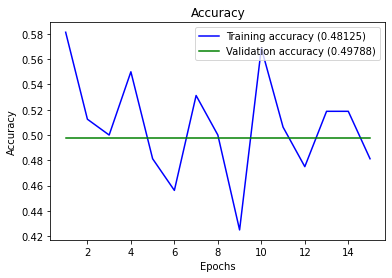

In [ ]:
plot_history(history1)

In [ ]:
# Model Evaluation
test_loss, test_acc = model.evaluate(X_test1,  Y_test1, verbose=2)
print('\nTest accuracy:', test_acc)


625/625 - 0s - loss: 7.7039 - accuracy: 0.4948

Test accuracy: 0.49480000138282776


In [ ]:
#Model 2 with custom loss function
model_2 = keras.Sequential()
model_2.add(keras.layers.Dense(100, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.0001)))
model_2.add(keras.layers.Dropout(0.5))
model_2.add(keras.layers.Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.0001)))

model_2.add(keras.layers.Dense(1, activation='Softmax'))

opt = Adam(learning_rate=0.01)

model_2.compile(optimizer = opt, loss = cross_entropy_loss, metrics=['accuracy'])


In [ ]:
# no_of_epcohs = 15
# gradient_batch_size = 10

# history2 = model.fit(TG_w2v_Matrix_final, 
#                     dataset_sentiment,
#                     validation_split = 0.2,
#                     steps_per_epoch = 5,
#                     epochs= no_of_epcohs,
#                     batch_size=gradient_batch_size, verbose = 1)

In [ ]:
#plot_history(history2)

Testing with n = 0.9

In [ ]:
l = len(dataset) # No of rows in dataset which will be use for the no iteration to prepare the text level graph
p=2
n = 0.9
TG_w2v_Matrix_final2 = np.empty((0,100),dtype = np.float32) #Define the final Text Level W2V matrix after message passing agreegation. Which will be input feature matrix to ML model
node_emb_total = np.zeros((1,100), dtype = np.float32)



for i in range (0, l):
  token = dataset_text[i].split()
  node_emb_total = np.zeros((1,100), dtype = np.float32)
  if (node_emb_total[node_emb_total > 1E3] is True):
    print(node_emb_total[0])
  node_emb_total[0] = node_emb_total[0] + text_level_graph(token,p,n)
  
  TG_w2v_Matrix_final2 = np.append(TG_w2v_Matrix_final2, node_emb_total, axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in add


In [ ]:
TG_w2v_Matrix_final2.shape

(100000, 100)

In [ ]:
min_value = np.min(TG_w2v_Matrix_final2)
print(min_value)
max_value = np.max(TG_w2v_Matrix_final2)
print(max_value)

-inf
inf


In [ ]:
TG_w2v_Matrix_final2[TG_w2v_Matrix_final2 <= -1E308] = -1E20

In [ ]:
TG_w2v_Matrix_final2[TG_w2v_Matrix_final2 >= 1E50] = 1E20

In [ ]:
min_value = np.min(TG_w2v_Matrix_final2)
print(min_value)
max_value = np.max(TG_w2v_Matrix_final2)
print(max_value)

-1e+20
3.421124e+37


In [ ]:
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(TG_w2v_Matrix_final2, dataset_sentiment, test_size=0.2, random_state=37)
print('# Train data samples:', X_train2.shape[0])
print('# Test data samples:', X_test2.shape[0])
assert X_train2.shape[0] == Y_train2.shape[0]
assert X_test2.shape[0] == Y_test2.shape[0]

# Train data samples: 80000
# Test data samples: 20000


In [ ]:
no_of_epcohs = 15
gradient_batch_size = 32

history3 = model.fit(X_train2, 
                    Y_train2,
                    validation_split = 0.2,
                    steps_per_epoch = 5,
                    epochs= no_of_epcohs,
                    batch_size=gradient_batch_size, verbose = 1)

Epoch 1/15
5/5 [==============================] - 1s 167ms/step - loss: 7.0528 - accuracy: 0.5375 - val_loss: 7.6570 - val_accuracy: 0.4979
Epoch 2/15
5/5 [==============================] - 0s 105ms/step - loss: 8.1012 - accuracy: 0.4688 - val_loss: 7.6570 - val_accuracy: 0.4979
Epoch 3/15
5/5 [==============================] - 0s 111ms/step - loss: 6.8622 - accuracy: 0.5500 - val_loss: 7.6570 - val_accuracy: 0.4979
Epoch 4/15
5/5 [==============================] - 1s 161ms/step - loss: 7.4340 - accuracy: 0.5125 - val_loss: 7.6570 - val_accuracy: 0.4979
Epoch 5/15
5/5 [==============================] - 0s 102ms/step - loss: 8.1012 - accuracy: 0.4688 - val_loss: 7.6570 - val_accuracy: 0.4979
Epoch 6/15
5/5 [==============================] - 0s 102ms/step - loss: 6.8622 - accuracy: 0.5500 - val_loss: 7.6570 - val_accuracy: 0.4979
Epoch 7/15
5/5 [==============================] - 1s 161ms/step - loss: 7.2434 - accuracy: 0.5250 - val_loss: 7.6570 - val_accuracy: 0.4979
Epoch 8/15
5/5 [====

In [ ]:
# Model Evaluation
test_loss, test_acc = model.evaluate(X_test2,  Y_test2, verbose=2)
print('\nTest accuracy:', test_acc)


625/625 - 1s - loss: 7.7039 - accuracy: 0.4948

Test accuracy: 0.49480000138282776


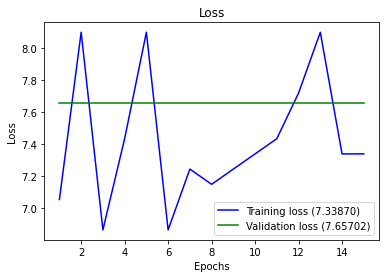

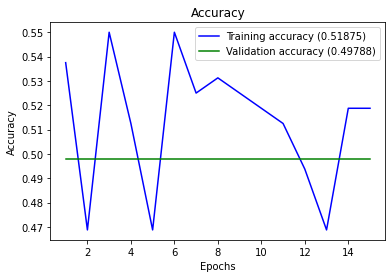

In [ ]:
plot_history(history3)